In [25]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import shutil
import re
import string
import matplotlib.pyplot as plt

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = keras.utils.get_file("aclImdb_v1", url, untar=True)
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 2s 0us/step


In [3]:
os.listdir(dataset_dir)

['test', 'imdbEr.txt', 'README', 'train', 'imdb.vocab']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'pos',
 'unsupBow.feat',
 'unsup',
 'urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'urls_neg.txt']

In [5]:
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['pos', 'urls_pos.txt', 'neg', 'labeledBow.feat', 'urls_neg.txt']

In [6]:
sample_path = os.path.join(train_dir, 'pos/2297_7.txt')
with open(sample_path) as f:
    print(f.read())

There's something about every "Hammer" movie I see that really takes me into a new fantasy world. In the world of "Hammer" movies, anything can happen. "Guardian of the Abyss" is one of those types of movies. It adventures deep into the occult and hypnosis to bring a different type of horror fantasy. All in all, an unforgettable movie. 7.5/10.


## Getting data ready

In [7]:
unsup_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(unsup_dir)

In [8]:
BATCH_SIZE = 32
SEED = 42

raw_train_dataset = tf.keras.utils.text_dataset_from_directory(
   train_dir,
   batch_size=BATCH_SIZE,
   seed = SEED,
   validation_split=0.2,
   subset='training'
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text, label in raw_train_dataset.take(1):
    for i in range(3):
        print("Review:", text.numpy()[i])
        print("Label:", label.numpy()[i])

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: 0
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get in

In [10]:
print(f"Label 0 corresponds to {raw_train_dataset.class_names[0]}")
print(f"Label 1 corresponds to {raw_train_dataset.class_names[1]}")

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_validation_dataset = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_dataset = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE
)

Found 25000 files belonging to 2 classes.


## Prepare for training

In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [14]:
custom_standardization("Hello, this is Alireza! I am very <br /> happy that I am here. Hay")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello this is alireza i am very   happy that i am here hay'>

In [15]:
MAX_FEATURES = 10000
SEQUENCE_LENGTH = 250

vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [16]:
train_text = raw_train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    vec = vectorize_layer(text)
    return vec, label

In [18]:
vectorize_text("Hello, I am Alireza and I am happy to be here", 1)

(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
 array([[5128,   10,  237,    1,    3,   10,  237,  654,    6,   26,  128,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0, 

In [19]:
vocab = vectorize_layer.get_vocabulary()

In [20]:
for i, v in enumerate(vocab):
    print(f"{i:6}:{v:>20} ", end=' ')
    if i % 3 == 0:
        print()

    if i > 1000:
        print("...")
        break

     0:                      
     1:               [UNK]       2:                 the       3:                 and  
     4:                   a       5:                  of       6:                  to  
     7:                  is       8:                  in       9:                  it  
    10:                   i      11:                this      12:                that  
    13:                 was      14:                  as      15:                 for  
    16:                with      17:               movie      18:                 but  
    19:                film      20:                  on      21:                 not  
    22:                 you      23:                 are      24:                 his  
    25:                have      26:                  be      27:                  he  
    28:                 one      29:                 its      30:                 all  
    31:                  at      32:                  by      33:                  an  
  

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = raw_train_dataset.map(vectorize_text, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(AUTOTUNE)

validation_dataset = raw_validation_dataset.map(vectorize_text, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.cache()
validation_dataset = validation_dataset.prefetch(AUTOTUNE)

test_dataset = raw_test_dataset.map(vectorize_text, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(AUTOTUNE)

## Create a model

In [22]:
EMBEDDING_DIM = 16

model = keras.Sequential([
    keras.layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),
    keras.layers.Dropout(0.2),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [23]:
model.compile(
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    optimizer='Adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

In [24]:
EPOCHS = 30
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)

Epoch 1/30
625/625 [==============================] - 51s 77ms/step - loss: 0.6659 - binary_accuracy: 0.6845 - val_loss: 0.6167 - val_binary_accuracy: 0.7712
Epoch 2/30
625/625 [==============================] - 3s 4ms/step - loss: 0.5500 - binary_accuracy: 0.7976 - val_loss: 0.4990 - val_binary_accuracy: 0.8214
Epoch 3/30
625/625 [==============================] - 3s 4ms/step - loss: 0.4459 - binary_accuracy: 0.8443 - val_loss: 0.4204 - val_binary_accuracy: 0.8468
Epoch 4/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3790 - binary_accuracy: 0.8665 - val_loss: 0.3738 - val_binary_accuracy: 0.8614
Epoch 5/30
625/625 [==============================] - 3s 5ms/step - loss: 0.3363 - binary_accuracy: 0.8794 - val_loss: 0.3449 - val_binary_accuracy: 0.8678
Epoch 6/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3055 - binary_accuracy: 0.8888 - val_loss: 0.3258 - val_binary_accuracy: 0.8714
Epoch 7/30
625/625 [==============================] - 3s 4ms/s

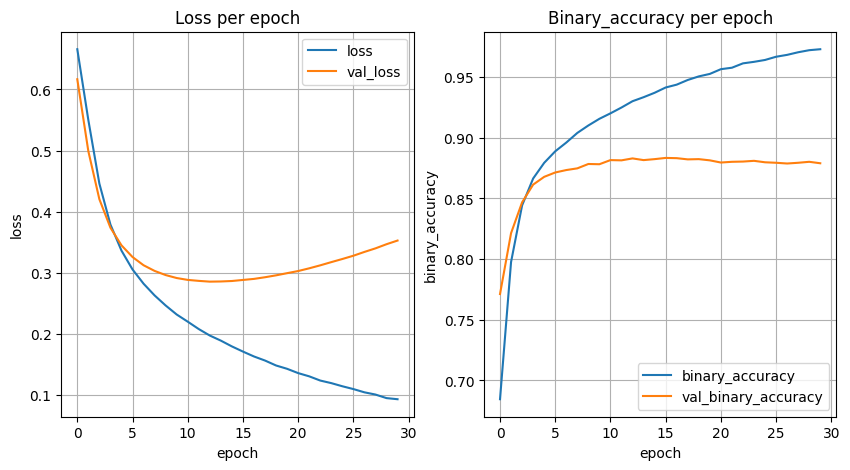

In [29]:
metrics = ['loss', 'binary_accuracy']

fig = plt.figure(figsize=(10, 5))
for i in range(1, len(metrics) + 1):
    ax = plt.subplot(1, len(metrics), i)
    ax.plot(history.epoch, history.history[metrics[i - 1]], label=metrics[i-1])
    ax.plot(history.epoch, history.history['val_'+metrics[i - 1]], label='val_'+metrics[i-1])
    ax.set_title(f"{metrics[i-1].capitalize()} per epoch")
    ax.set_xlabel('epoch')
    ax.set_ylabel(metrics[i-1])
    ax.grid()
    ax.legend()

## Evaluation and export

In [32]:
export_model = keras.Sequential([
    vectorize_layer,
    model,
    keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss='binary_cross_entropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [33]:
examples = [
    'The movie was greate!',
    'The movie was terrible',
    'I didn\'t like the movie'
]

export_model.predict(examples)

1/1 [==============================] - 0s 363ms/step


array([[0.56767464],
       [0.29864234],
       [0.5588187 ]], dtype=float32)

In [34]:
examples = [
    'The movie was not good, it was bad',
    'The movie was good, it was not bad'
]

export_model.predict(examples)

1/1 [==============================] - 0s 93ms/step


array([[0.3879039],
       [0.3879039]], dtype=float32)